# How to extract Functional Connectivity on resting-state fMRI



In [ ]:
!pip install nilearn pandas matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 29.5 MB/s eta 0:00:00


# 1. Extract timeseries and build connectivity given Brain ROIs


## 1.1. About resting-state fMRI dataset

## The neural basis of Attention Deficit Hyperactivity Disorder (ADHD)
## - N=973 (352 F)
## - 585 TD, 362 ADHD
## - Age range 7-27 years)
## - Modality: rsfMRI + sMRI gathered across 8 independent sites
## - Accompanying phenotypic information includes: diagnostic status, dimensional ADHD symptom measures, age, sex, intelligence quotient (IQ) and lifetime medication status.

### Source: http://preprocessed-connectomes-project.org/adhd200/index.html

## 1.2. Download ADHD dataset with Nilearn `nilearn.datasets.fetch_adhd`

In [ ]:
from nilearn import datasets

In [ ]:
adhd_dataset = datasets.fetch_adhd(n_subjects=1, data_dir='./nilearn_data')


Added README.md to ./nilearn_data


Dataset created in ./nilearn_data/adhd



 ...done. (0 seconds, 0 min)
Extracting data from ./nilearn_data/adhd/fbef5baff0b388a8c913a08e1d84e059/adhd40_metadata.tgz..... done.


Downloaded 19243008 of 44414948 bytes (43.3%,    1.3s remaining) ...done. (2 seconds, 0 min)
Extracting data from ./nilearn_data/adhd/e7ff5670bd594dcd9453e57b55d69dc9/adhd40_0010042.tgz..... done.


In [ ]:
print(adhd_dataset.keys())

dict_keys(['func', 'confounds', 'phenotypic', 'description'])


In [ ]:
import pandas as pd

phenotypes = pd.read_table(adhd_dataset['confounds'][0])
print(phenotypes)

              csf  constant  linearTrend           wm        global  \
0    12140.708282       1.0          0.0  9322.722489   9955.469315   
1    12123.146913       1.0          1.0  9314.257684   9947.987176   
2    12085.963127       1.0          2.0  9319.610045   9945.132852   
3    12109.299348       1.0          3.0  9299.841075   9943.648622   
4    12072.330305       1.0          4.0  9297.870869   9925.640852   
..            ...       ...          ...          ...           ...   
171  12298.572860       1.0        171.0  9406.767044  10066.579290   
172  12289.404279       1.0        172.0  9427.420559  10050.431735   
173  12275.893609       1.0        173.0  9429.867935  10046.053862   
174  12248.721666       1.0        174.0  9397.268728  10033.648380   
175  12252.693409       1.0        175.0  9390.238156  10041.429636   

     motion-pitch  motion-roll  motion-yaw  motion-x  motion-y  motion-z  \
0         -0.0637       0.1032     -0.1516   -0.0376   -0.0112    0.084

## 1.3. Brain ROIs -- Harvard-Oxford Atlas `nilearn.datasets.fetch_atlas_harvard_oxford`

## Source: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Atlases

In [ ]:
harvard_oxford_atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')


Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/fsl



Downloaded 19382272 of 25716861 bytes (75.4%,    0.3s remaining) ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/fsl/c4d84bbdf5c3325f23e304cdea1e9706/HarvardOxford.tgz..... done.


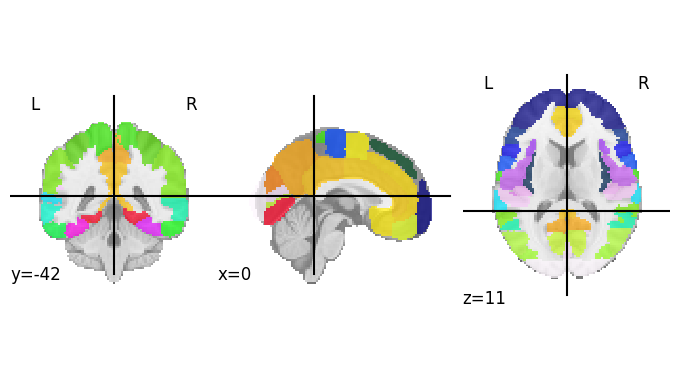

In [ ]:
# Location of HarvardOxford parcellation atlas
atlas_file = harvard_oxford_atlas.maps

from nilearn import plotting
# Visualize parcellation atlas
plotting.plot_roi(atlas_file)

In [ ]:
# Load labels for each atlas region
labels = harvard_oxford_atlas.labels[1:]
print(labels[:10])
print(len(labels))

['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division']
48


## 1.4. Extract timeseries signals `nilearn.maskers.NiftiLabelsMasker`

In [ ]:
from nilearn.maskers import NiftiLabelsMasker

labels_masker = NiftiLabelsMasker(labels_img=atlas_file, standardize=True, verbose=1)

### 1.4.1. Cleaning confounds

In [ ]:
time_series = labels_masker.fit_transform(adhd_dataset.func[0], confounds=adhd_dataset.confounds[0])

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals


In [ ]:
print(time_series.shape)

(176, 48)


## 1.5. Estimate correlation matrix `nilearn.connectome.ConnectivityMeasure`

In [ ]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

In [ ]:
print(correlation_matrix.shape)

(48, 48)


## 1.6. Visualize correlation matrix `nilearn.plotting.plot_matrix`

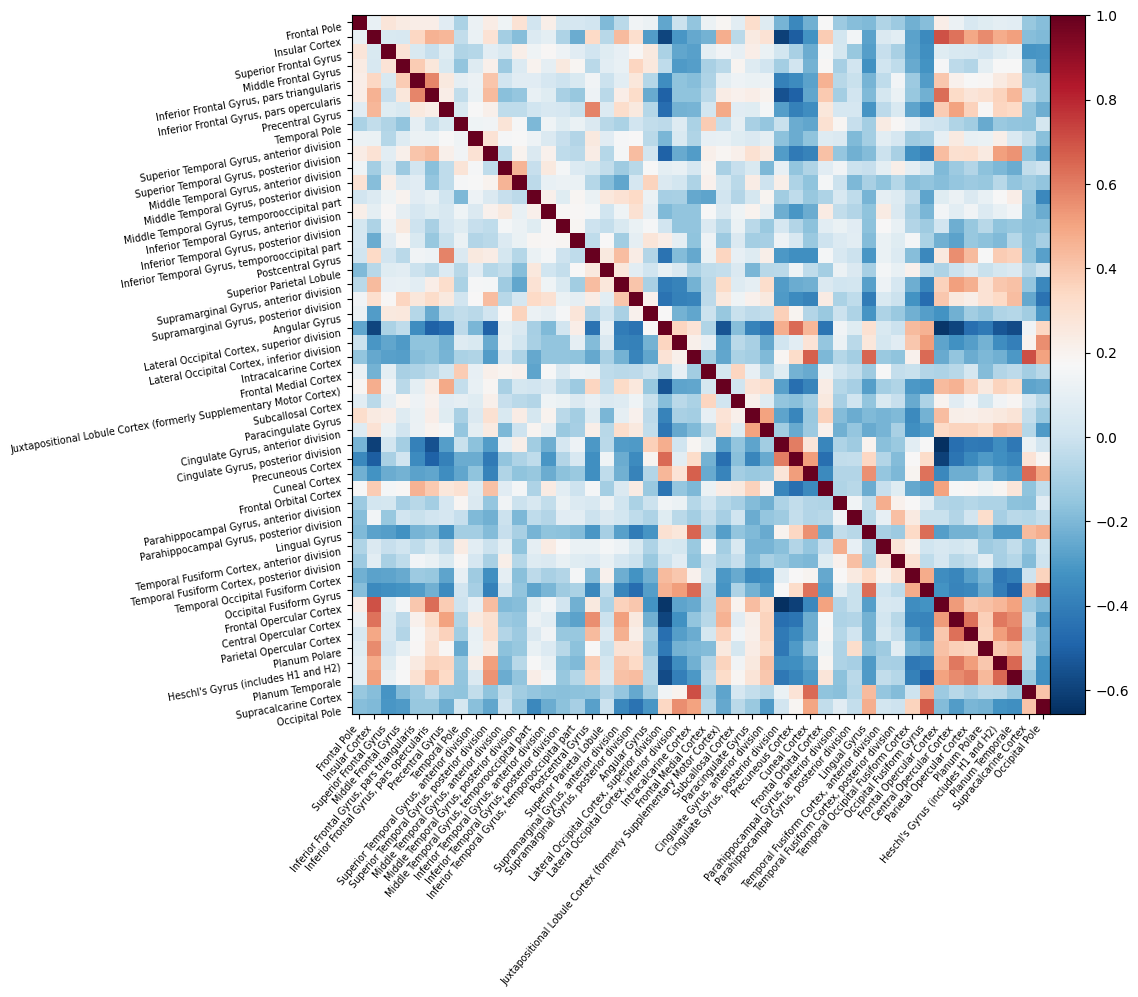

In [ ]:
# Plot correlation matrix - note: matrix is ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels)

## 1.7. Visualize connectivity matrix `nilearn.plotting.plot_connectome`

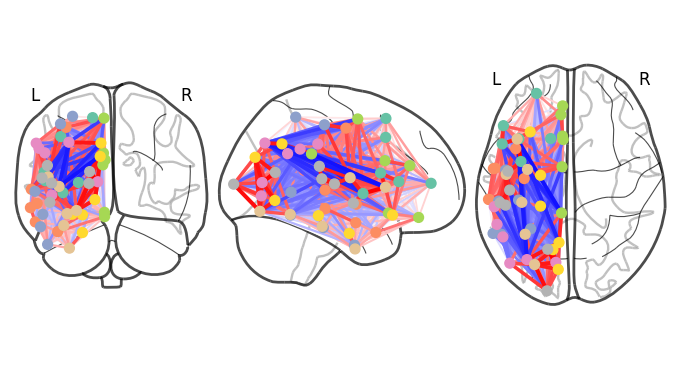

In [ ]:
coords = plotting.find_parcellation_cut_coords(atlas_file)

plotting.plot_connectome(correlation_matrix, node_coords=coords)

In [ ]:
%matplotlib notebook

plotting.view_connectome(correlation_matrix, coords)

## 1.8. Repeat the same steps without removing confounds

In [ ]:
# Extract the signal from the regions
time_series_bad = labels_masker.fit_transform(adhd_dataset.func[0]) # Note that we haven't specify confounds here

# Compute the correlation matrix
correlation_matrix_bad = correlation_measure.fit_transform([time_series_bad])[0]

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.transform_single_imgs] Loading data from nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals


### 1.8.1. Compare with and without removing confounds

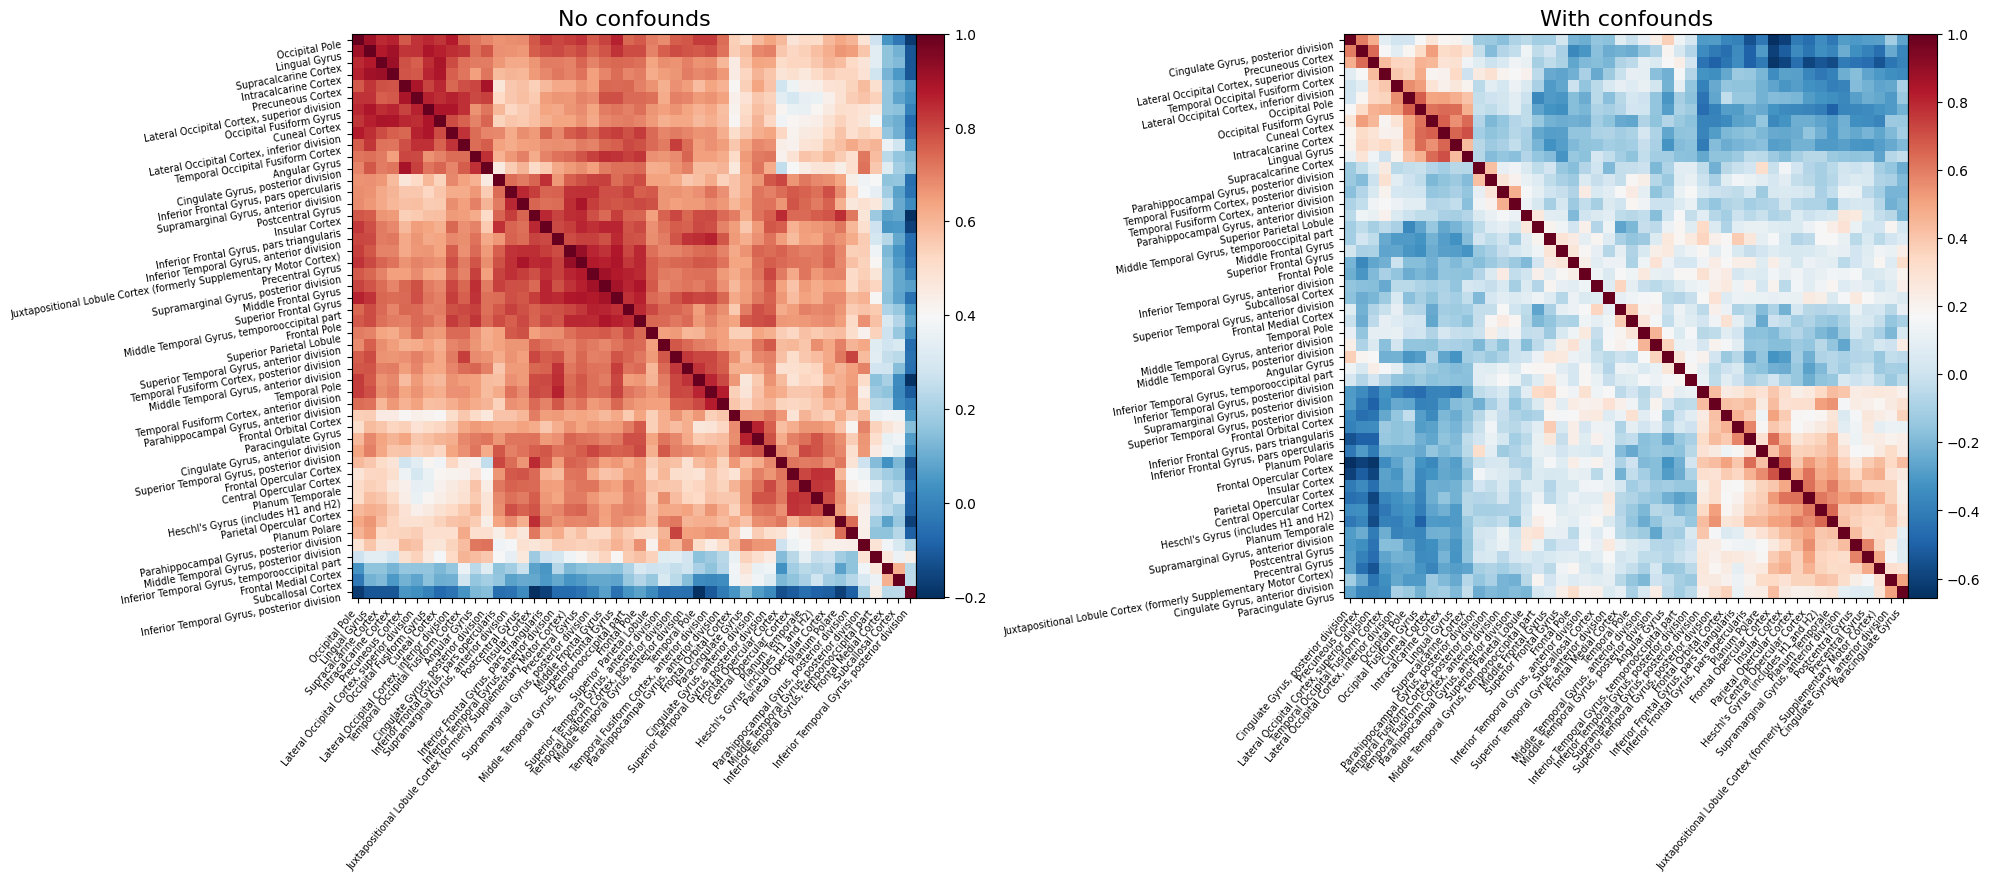

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(20, 15), ncols=2)

# Plot the correlation matrix
plotting.plot_matrix(correlation_matrix_bad, labels=labels,
                     title='No confounds', reorder=True, axes=axes[0])
plotting.plot_matrix(correlation_matrix, labels=labels,
                     title='With confounds', reorder=True, axes=axes[1])

# 2. Extract seed-based timeseries and build seed-to-voxel connectivity maps

In [ ]:
# Sphere radius in mm
seed_radius = 8

# Sphere center in MNI-coordinate
seed_coords = [(0, -52, 18)]

## 2.1. Extract timeseries signals based on seed `nilearn.maskers.NiftiSpheresMasker`

In [ ]:
from nilearn.input_data import NiftiSpheresMasker
seed_masker = NiftiSpheresMasker(seed_coords, radius=seed_radius, detrend=True,
                                 standardize=True, low_pass=0.1, high_pass=0.01,
                                 t_r=2.0, verbose=1)

In [ ]:
seed_time_series = seed_masker.fit_transform(adhd_dataset.func[0], confounds=adhd_dataset.confounds[0])

[NiftiSpheresMasker.transform_single_imgs] Loading data from nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Extracting region signals
[NiftiSpheresMasker.transform_single_imgs] Cleaning extracted signals


## 2.2. Next, extract whole brain voxel-level timeseries signals `nilearn.maskers.NiftiMasker`

In [ ]:
from nilearn.input_data import NiftiMasker
brain_masker = NiftiMasker(smoothing_fwhm=6, detrend=True, standardize=True,
                           low_pass=0.1, high_pass=0.01, t_r=2., verbose=1)

In [ ]:
brain_time_series = brain_masker.fit_transform(adhd_dataset.func[0],
                                               confounds=adhd_dataset.confounds[0])

[NiftiMasker.fit] Loading data from nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiMasker.fit] Computing the mask
[NiftiMasker.fit] Resampling mask
[NiftiMasker.fit] Finished fit
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


## 2.3. Perform seed-based correlation analysis

In [ ]:
import numpy as np
seed_based_correlations = np.dot(brain_time_series.T, seed_time_series)
seed_based_correlations /= seed_time_series.shape[0]

In [ ]:
print(seed_based_correlations.shape)

(69681, 1)


## 2.4. Plotting the seed-based correlation map `nilearn.plotting.plot_stat_map`

In [ ]:
seed_based_correlation_img = brain_masker.inverse_transform(seed_based_correlations.T)

In [ ]:
print(seed_based_correlation_img.shape)

(61, 73, 61, 1)


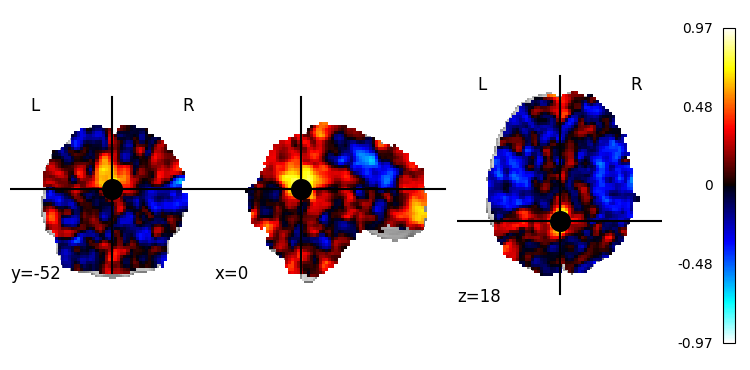

In [ ]:
from nilearn import image

display = plotting.plot_stat_map(image.index_img(seed_based_correlation_img, 0),
                                 cut_coords=seed_coords[0])
display.add_markers(marker_coords=[seed_coords[0]], marker_color='black',
                    marker_size=200)